Reading CSV file...

Data Statistics:
Total data points: 572,416
Time range: nan to nan seconds
Velocity range: nan to nan
Using window size: 5,720 points

Smoothing data...

Suggested window size range: 572 to 5,724

Testing different prominence thresholds:
Prominence 1.00e-16: found 0 peaks
Prominence 1.00e-15: found 0 peaks
Prominence 1.00e-14: found 0 peaks
Prominence 1.00e-13: found 0 peaks

No events detected with prominence threshold 1.00e-01
Try adjusting parameters:
1. Increase window_size (current: 5,720)
2. Lower prominence_threshold (current: 1.00e-01)


ValueError: array of sample points is empty

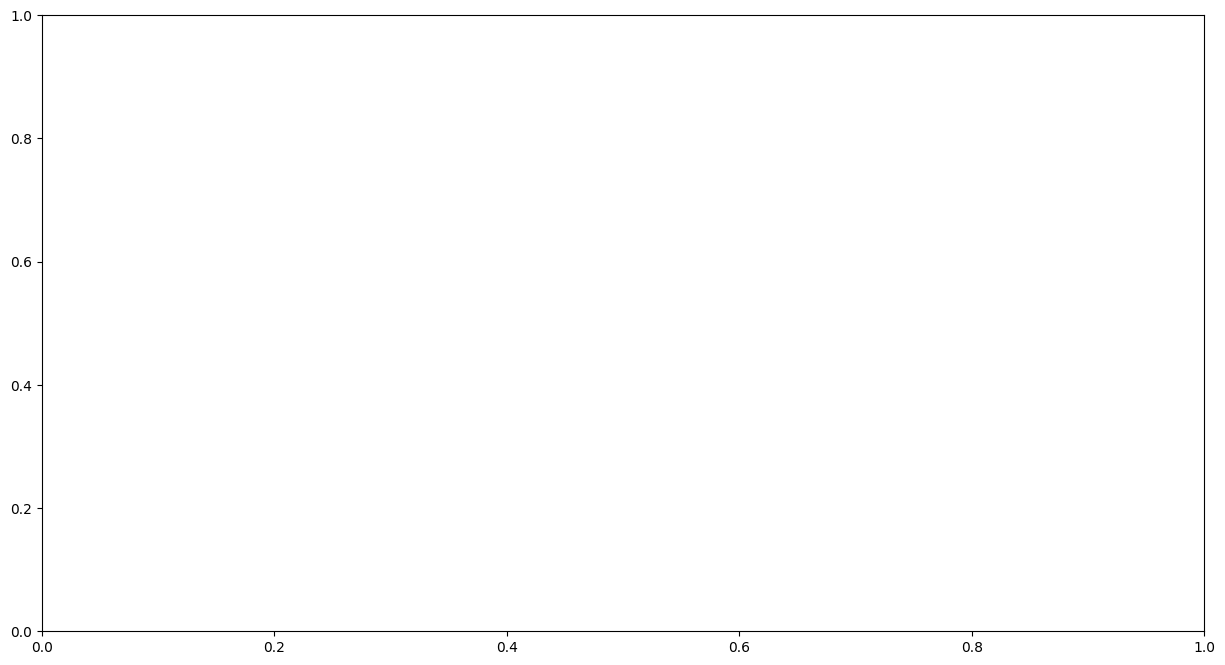

Most relevant moonquake detected at index: 550757


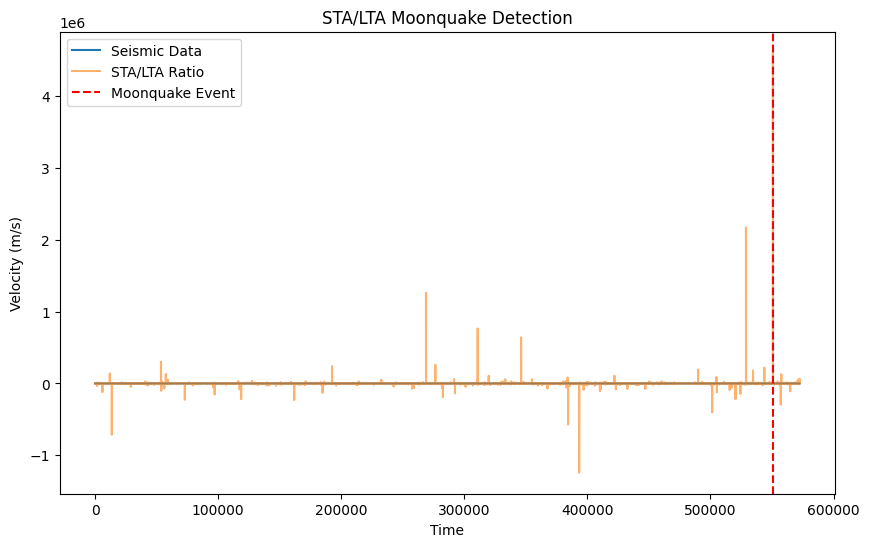

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('xa.s12.00.mhz.1970-01-19HR00_evid00002.csv')



def sta_lta(data, sta_window, lta_window):
    sta = data.rolling(window=sta_window).mean()
    lta = data.rolling(window=lta_window).mean()
    return sta / lta

sta_window = 10
lta_window = 100

def plot_the_points(df):
  plt.figure(figsize=(10, 6))
  plt.plot(df['velocity(m/s)'], label='Seismic Data')
  plt.plot(df['sta_lta_ratio'], label='STA/LTA Ratio', alpha=0.6)
  if most_relevant_event:
      plt.axvline(x=most_relevant_event, color='r', label='Moonquake Event', linestyle='--')

  plt.legend()
  plt.title('STA/LTA Moonquake Detection')
  plt.xlabel('Time')
  plt.ylabel('Velocity (m/s)')
  plt.show()


def find_most_relevant_event(df, min_distance=500):
    df['sta_lta_ratio'] = sta_lta(df['velocity(m/s)'], sta_window, lta_window)

    threshold = 3
    df['is_moonquake'] = df['sta_lta_ratio'] > threshold

    event_points = df[df['is_moonquake']].index

    if len(event_points) == 0:
        return None

    max_point = df.loc[event_points, 'sta_lta_ratio'].idxmax()
    print(f"Most relevant moonquake detected at index: {most_relevant_event}")
    return max_point

most_relevant_event = find_most_relevant_event(df)
plot_the_points(df)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing file: xa.s12.00.mhz.1970-03-25HR00_evid00003.csv
Data shape: (572411, 3)
Detected event points: []
Classified data: [], Classified labels: []
No classified data for xa.s12.00.mhz.1970-03-25HR00_evid00003.csv
Processing file: xa.s12.00.mhz.1970-01-19HR00_evid00002.csv
Data shape: (572415, 3)
Detected event points: []
Classified data: [], Classified labels: []
No classified data for xa.s12.00.mhz.1970-01-19HR00_evid00002.csv
Processing file: xa.s12.00.mhz.1970-04-26HR00_evid00007.csv
Data shape: (572411, 3)
Detected event points: []
Classified data: [], Classified labels: []
No classified data for xa.s12.00.mhz.1970-04-26HR00_evid00007.csv
Processing file: xa.s12.00.mhz.1970-04-25HR00_evid00006.csv
Data shape: (572415, 3)
Detected event points: []
Classified data: [], Classified labels: []
No classified data for xa.s12.00.mhz.1970-04-25HR00_evid00006

ValueError: need at least one array to concatenate

In [24]:
# Function to process all CSV files in a folder and prepare data for LSTM
def process_csv_folder(folder_path, sta_window, lta_window, threshold, bin_labels, window_size):
    all_classified_data = []
    all_classified_labels = []

    # Loop through each CSV file in the directory
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)

            print(f"Processing file: {file_name}")  # Debug: which file is being processed
            print(f"Data shape: {df.shape}")  # Debug: shape of the DataFrame

            # Assuming the 'velocity(m/s)' column exists
            event_points = find_event_points(df, sta_window, lta_window, threshold)
            print(f"Detected event points: {event_points}")  # Debug: event points detected

            classified_data, classified_labels = classify_data(df, event_points, bin_labels)
            print(f"Classified data: {classified_data}, Classified labels: {classified_labels}")  # Debug: data and labels

            if classified_data:  # Check if there is any classified data
                all_classified_data.extend(classified_data)
                all_classified_labels.extend(classified_labels)
            else:
                print(f"No classified data for {file_name}")  # Debug: if no data was classified

    if not all_classified_data or not all_classified_labels:
        print("Warning: No classified data or labels found across all files.")  # Debug: check overall status

    return np.array(all_classified_data), np.array(all_classified_labels)


Processing file: xa.s12.00.mhz.1970-03-25HR00_evid00003.csv
Data shape: (572411, 3)
Detected event points: [     2      6      7 ... 572207 572208 572209]


KeyboardInterrupt: 

In [8]:
import pandas as pd
import numpy as np
import os

# Function to find event points based on STA/LTA ratio
def find_event_points(df, sta_window, lta_window, threshold):
    # Calculate the Short-Term Average (STA) and Long-Term Average (LTA)
    velocity = df['velocity(m/s)'].values

    # Calculate STA and LTA using convolution
    sta = np.convolve(velocity, np.ones(sta_window), 'valid') / sta_window
    lta = np.convolve(velocity, np.ones(lta_window), 'valid') / lta_window

    # Ensure both arrays are the same length
    min_length = min(len(sta), len(lta))
    sta = sta[:min_length]
    lta = lta[:min_length]

    # Calculate the ratio and find event points
    ratio = sta / lta
    event_points = np.where(ratio > threshold)[0]

    return event_points

# Function to classify data into bins based on event points
def classify_data(df, event_points, bin_labels):
    classified_data = []
    classified_labels = []

    for event in event_points:
        for bin_label in bin_labels:
            start_time = event - bin_label
            end_time = event + bin_label

            if start_time >= 0 and end_time < len(df):
                data_segment = df.iloc[start_time:end_time]['velocity(m/s)'].values
                classified_data.append(data_segment)
                classified_labels.append(bin_label)  # Classify by bin label

    return classified_data, classified_labels

# Function to process all CSV files in a folder and prepare data for LSTM
def process_csv_folder(folder_path, sta_window, lta_window, threshold, bin_labels, max_files=None):
    all_classified_data = []
    all_classified_labels = []

    # Limit the number of files processed if max_files is specified
    file_count = 0

    # Loop through each CSV file in the directory
    for file_name in ['/content/xa.s12.00.mhz.1970-06-15HR00_evid00008.csv','/content/xa.s12.00.mhz.1970-04-26HR00_evid00007.csv','/content/xa.s12.00.mhz.1970-04-25HR00_evid00006.csv','/content/xa.s12.00.mhz.1970-03-26HR00_evid00004.csv','/content/xa.s12.00.mhz.1970-03-25HR00_evid00003.csv','/content/xa.s12.00.mhz.1970-01-19HR00_evid00002.csv']:
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)

            print(f"Processing file: {file_name}")  # Debug: which file is being processed
            print(f"Data shape: {df.shape}")  # Debug: shape of the DataFrame

            event_points = find_event_points(df, sta_window, lta_window, threshold)
            print(f"Detected event points: {event_points}")  # Debug: event points detected

            classified_data, classified_labels = classify_data(df, event_points, bin_labels)
            print(f"Classified data length: {len(classified_data)}, Classified labels length: {len(classified_labels)}")  # Debug: data and labels

            if classified_data:  # Check if there is any classified data
                all_classified_data.extend(classified_data)
                all_classified_labels.extend(classified_labels)
            else:
                print(f"No classified data for {file_name}")  # Debug: if no data was classified

            file_count += 1
            if max_files is not None and file_count >= max_files:
                break  # Stop processing if max_files limit is reached

    if not all_classified_data or not all_classified_labels:
        print("Warning: No classified data or labels found across all files.")  # Debug: check overall status

    return np.array(all_classified_data), np.array(all_classified_labels)

# Example usage
folder_path = '/content/drive/MyDrive/s12csvonly'  # Replace with your folder path
sta_window = 50  # Short-Term Average window
lta_window = 200  # Long-Term Average window
threshold = 1.5  # Threshold for event detection
bin_labels = [3, 6, 9, 12, 15, 18, 21, 24]  # Labels for classification
max_files = 15  # Limit the number of files to process

# Process the CSV files and prepare data for LSTM
X, y = process_csv_folder(folder_path, sta_window, lta_window, threshold, bin_labels, max_files)

# Check shapes of output
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")


Processing file: /content/xa.s12.00.mhz.1970-06-15HR00_evid00008.csv
Data shape: (572418, 3)
Detected event points: [     8     49     66 ... 572216 572217 572218]
Classified data length: 2168266, Classified labels length: 2168266
Processing file: /content/xa.s12.00.mhz.1970-04-26HR00_evid00007.csv
Data shape: (572411, 3)
Detected event points: [    78     79    102 ... 572204 572205 572206]
Classified data length: 2372896, Classified labels length: 2372896
Processing file: /content/xa.s12.00.mhz.1970-04-25HR00_evid00006.csv
Data shape: (572415, 3)
Detected event points: [     7      8      9 ... 572201 572202 572203]
Classified data length: 2321145, Classified labels length: 2321145
Processing file: /content/xa.s12.00.mhz.1970-03-26HR00_evid00004.csv
Data shape: (572411, 3)
Detected event points: [     0      1      2 ... 572188 572189 572199]
Classified data length: 2295743, Classified labels length: 2295743
Processing file: /content/xa.s12.00.mhz.1970-03-25HR00_evid00003.csv
Data sh

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (13564437,) + inhomogeneous part.

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


In [7]:
def build_lstm_model(input_shape):
    model = Sequential()

    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=16, activation='relu'))

    model.add(Dense(units=len(np.unique(y)), activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def preprocess_data(X, y, test_size=0.2):
    X = np.array(X)
    y = np.array(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(X, y)

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {accuracy:.4f}")

NameError: name 'X' is not defined